In [ ]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [ ]:
FIG_SIZE = (5,4.5)
FONTSIZE = 16
LINESTYLE = (0,(4,4))
SAVE_FIG = False

START_TIME = 1.0 # in seconds
BW = 25e9 # in bps
PORT_NO_START = 1000
NUM_SENDERS = 4
BATCH_SIZE = 16

BOLT_HDR_SIZE = 26. # Bytes
IP_HDR_SIZE = 20.   # Bytes
MTU = 5000.         # Bytes
PKT_PAYLOAD_SIZE = MTU - IP_HDR_SIZE - BOLT_HDR_SIZE

workload = 'Google_RPC_read'
# workload = 'Facebook_Hadoop'
note = '' # Should start with a _
load = 0.8
simIdx = 0

trace_path = 'outputs/bolt-testbed-benchmarks/'
trace_path += workload + '_load-' + str(int(load*100)) + 'p_'
trace_path += 'nFlows-' + str(NUM_SENDERS) + '_' + str(simIdx) + '_'
trace_path += 'MSGAGG_'

log_files = {
    'bolt' : trace_path + 'DEFAULT' + note + '.log',
    'swift': trace_path + 'SWIFT' + '.log'
}

In [ ]:
#@title
def get_pctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [ ]:
#@title
def readQueueLog(filename, num_hosts):
  times = [[] for i in range(num_hosts)]
  q_sizes = [[] for i in range(num_hosts)]
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[0])*1e-9 - START_TIME # in seconds
        host = int(queue_log[1])
        q_size = float(queue_log[2]) * 8.0 / BW * 1e-3 # in usec
      except:
        continue

      times[host].append(time)
      q_sizes[host].append(q_size)

  retval = {}
  retval['times'] = times
  retval['q_sizes'] = q_sizes
  return retval

In [ ]:
#@title
def readFlowStats(flow_stats_filename):
  flow_stats = {}
  with open(flow_stats_filename, 'r') as f:
    for line in f:
      flow_stat_log = line.split()

      time = float(flow_stat_log[0])*1e-9 - START_TIME # in seconds
      sender = flow_stat_log[1]
      cwnd = float(flow_stat_log[4]) # in bytes
      rtt = float(flow_stat_log[5]) * 1e-3 # in usec

      if (rtt != 0):
        rate = cwnd * 8.0 / rtt * 1e-3 # in Gbps
      elif (cwnd != 0):
        rate = BW

      if sender in flow_stats.keys():
        flow_stats[sender]['times'].append(time)
        flow_stats[sender]['rates'].append(rate)
        flow_stats[sender]['cwnds'].append(cwnd)
        flow_stats[sender]['rtts'].append(rtt)
      else:
        flow_stats[sender] = {}
        flow_stats[sender]['times'] = [time]
        flow_stats[sender]['rates'] = [rate]
        flow_stats[sender]['cwnds'] = [cwnd]
        flow_stats[sender]['rtts'] = [rtt]

  return flow_stats

In [ ]:
#@title
def testbedRttStats(rtt_stats_filename):
  rtt_stats = {}
  with open(rtt_stats_filename, 'r') as f:
    for line in f:
      rtt_stat_log = line.split()

      bucket = rtt_stat_log[0].split('…')
      bucket_l = float(bucket[0][1:])
      bucket_r = float(bucket[1][:-1])

      prob = float(rtt_stat_log[2][:-1])
      cum_prob = float(rtt_stat_log[3][:-1])/100.

      if 'bucket_l' in rtt_stats.keys():
        rtt_stats['bucket_l'].append(bucket_l)
        rtt_stats['bucket_r'].append(bucket_r)
        rtt_stats['prob'].append(prob)
        rtt_stats['cum_prob'].append(cum_prob)
      else:
        rtt_stats['bucket_l'] = [bucket_l]
        rtt_stats['bucket_r'] = [bucket_r]
        rtt_stats['prob'] = [prob]
        rtt_stats['cum_prob'] = [cum_prob]

  return rtt_stats

In [ ]:
#@title
data = {}
for algo, flow_stats_filename in log_files.items():
  trim_size = 4
  if (algo == 'bolt'):
    trim_size += len(note)
  testbed_stats_filename = flow_stats_filename[:-trim_size] + '_testbed.log'
  testbed_stats_filename = testbed_stats_filename.replace('_MSGAGG', '')
  data[algo] = {
      'sim_stats': readFlowStats(flow_stats_filename),
      'testbed_stats': testbedRttStats(testbed_stats_filename)
  }

In [ ]:
#@title
for algo, flow_stats_filename in log_files.items():
  data[algo]['all_rtts'] = []
  for sender, sim_stats in data[algo]['sim_stats'].items():
    data[algo]['all_rtts'] += [rtt for rtt in sim_stats['rtts'] if rtt != 0] 
  data[algo]['all_rtts'].sort()

bolt - Google_RPC_read - 


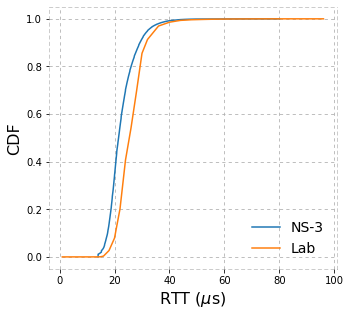

swift - Google_RPC_read - 


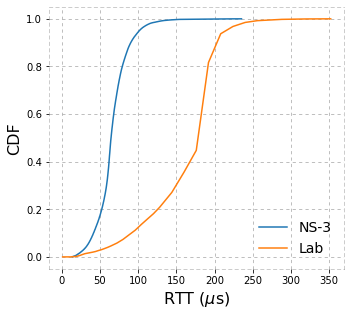

In [ ]:
#@title
for algo, d in data.items():
  print(algo + ' - ' + workload + ' - ' + note)
  plt.figure(figsize=FIG_SIZE)

  sim_rtts = d['all_rtts']
  plt.plot(sim_rtts, 
           [i/len(sim_rtts) for i in range(len(sim_rtts))], 
           label='NS-3')
  plt.plot(d['testbed_stats']['bucket_r'], 
           d['testbed_stats']['cum_prob'], 
           label='Lab')

  plt.ylabel('CDF', fontsize=FONTSIZE)
  plt.xlabel('RTT ($\mu$s)', fontsize=FONTSIZE)
  plt.legend(frameon=False, fontsize=FONTSIZE-2)
  plt.grid(linestyle =LINESTYLE)
  plt.gca().spines["right"].set_linestyle(LINESTYLE)
  plt.gca().spines["right"].set_alpha(0.5)
  plt.gca().spines["right"].set_color('gray')
  plt.gca().spines["left"].set_linestyle(LINESTYLE)
  plt.gca().spines["left"].set_alpha(0.5)
  plt.gca().spines["left"].set_color('gray')
  plt.gca().spines["top"].set_linestyle(LINESTYLE)
  plt.gca().spines["top"].set_alpha(0.5)
  plt.gca().spines["top"].set_color('gray')
  plt.gca().spines["bottom"].set_linestyle(LINESTYLE)
  plt.gca().spines["bottom"].set_alpha(0.5)
  plt.gca().spines["bottom"].set_color('gray')
  plt.tight_layout()
  plt.show()

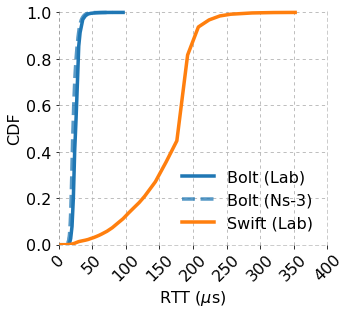

In [ ]:
#@title
plt.figure(figsize=FIG_SIZE)

plt.plot(data['bolt']['testbed_stats']['bucket_r'], 
         data['bolt']['testbed_stats']['cum_prob'], 
         label='Bolt (Lab)', linewidth=3.5, color='C0')

sim_rtts = data['bolt']['all_rtts']
plt.plot(sim_rtts, 
         [i/len(sim_rtts) for i in range(len(sim_rtts))], label='Bolt (Ns-3)', 
         linewidth=3.5, color='C0', linestyle='--', alpha=0.75)


plt.plot(data['swift']['testbed_stats']['bucket_r'], 
         data['swift']['testbed_stats']['cum_prob'],
         label='Swift (Lab)', linewidth=3.5, color='C1')

plt.ylabel('CDF', fontsize=FONTSIZE)
plt.xlabel('RTT ($\mu$s)', fontsize=FONTSIZE)
plt.xticks(rotation=45, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.ylim([0,1.01])
plt.xlim([0,400])
plt.legend(frameon=False, fontsize=FONTSIZE)
plt.grid(linestyle =LINESTYLE)
plt.gca().spines["right"].set_linestyle(LINESTYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINESTYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_linestyle(LINESTYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

if (SAVE_FIG):
  save_folder = '/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/'
  save_filename = 'lab_vs_sim_' + workload + '_load-' + str(int(load*100)) + 'p' + note + '.pdf'
  plt.savefig(save_folder + save_filename)
plt.show()

In [ ]:
#@title
print("50%ile simulation RTT: " + str(get_pctl(sim_rtts, 0.5)) + " usec")
print("99%ile simulation RTT: " + str(get_pctl(sim_rtts, 0.99)) + " usec")

50%ile simulation RTT: 21.473 usec
99%ile simulation RTT: 39.023 usec
